In [14]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from pathlib import Path

In [4]:
# Specify the folder path where the CSV files are stored
folder_path =Path("/storage_common/nobilm/broken_test/")

# Get a list of all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
len(csv_files)

34171

In [5]:
# Check if there are any CSV files in the folder
if not csv_files:
    print(f"No CSV files found in {str(folder_path)}")
else:
    # Initialize an empty list to store individual DataFrames
    dfs = []

    # Loop through each CSV file and read it into a DataFrame
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate the list of DataFrames into a single DataFrame
    concatenated_df = pd.concat(dfs, ignore_index=True)    

In [6]:
concatenated_df.head()

,Unnamed: 0,SMILES_aae,NUM_ATOMS,NUM_BONDS,WEIGHT_aae,SMILES_asinex,WEIGHT_asinex,tanimoto
0,0,Cn1cc(C2CCCN2C(=O)c2cccc(CCC(C)(C)O)c2)cn1,25,27,341.210327,O=C1NC(=S)NC(=O)C1=Cc1ccc(N2CCOCC2)c([N+](=O)[...,362.068491,0.250394
1,1,Cn1cc(C2CCCN2C(=O)c2cccc(CCC(C)(C)O)c2)cn1,25,27,341.210327,O=[N+]([O-])c1ccc(N/N=C/c2ccc3c(c2)OCCO3)c([N+...,344.075684,0.220223
2,2,Cn1cc(C2CCCN2C(=O)c2cccc(CCC(C)(C)O)c2)cn1,25,27,341.210327,Cn1c(=O)c(-c2cc([N+](=O)[O-])ccc2N)nc2cc([N+](...,341.076018,0.283737
3,3,Cn1cc(C2CCCN2C(=O)c2cccc(CCC(C)(C)O)c2)cn1,25,27,341.210327,Nc1[nH]c(=O)[nH]c(=O)c1C(c1ccccc1)c1c(N)[nH]c(...,342.107653,0.222513
4,4,Cn1cc(C2CCCN2C(=O)c2cccc(CCC(C)(C)O)c2)cn1,25,27,341.210327,CCc1nnc(N/N=C/c2ccc(-c3ccc([N+](=O)[O-])cc3)o2...,341.123637,0.263701


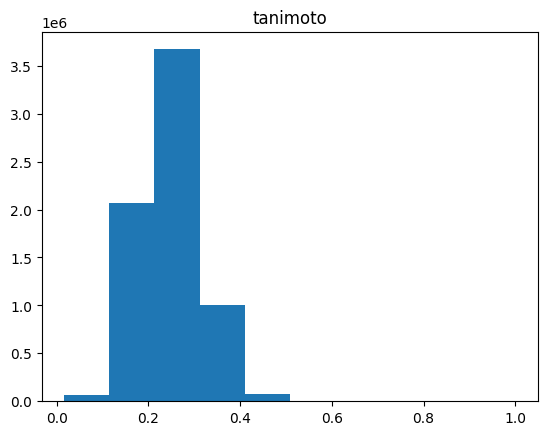

In [15]:
from data_utils import append_line_to_log, create_log, num_mols_over_treshold
from rdkit import Chem
from more_itertools import chunked
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

out_dir = "/storage_common/nobilm"
log = create_log(out_dir, name="analysis_log_test_aae_asinex_broken.txt")

out = concatenated_df
technique_name = "aae"  # os.path.split(Path(path).parent)[-1]


# ----- Log info ----- #
append_line_to_log(
    log, f"Number of generated mols considered in the analysis: {len(set(out['SMILES_'+technique_name]))}")
append_line_to_log(log, f"Exact matches: {num_mols_over_treshold(out, 1.)[1]}")
append_line_to_log(log, f"Average Tanimoto dist: {out['tanimoto'].mean()}")
t, n = num_mols_over_treshold(out, .7)
append_line_to_log(log, f"Mols above treshold ({t}): {n}")
t, n = num_mols_over_treshold(out)
append_line_to_log(log, f"Mols above treshold ({t}): {n}")
t, n = num_mols_over_treshold(out, .95)
append_line_to_log(log, f"Mols above treshold ({t}): {n}")
t, n = num_mols_over_treshold(out, .98)
append_line_to_log(log, f"Mols above treshold ({t}): {n}")

# ----- Tanimoto hist ----- #
name_tanimoto_png = technique_name + '_tanimoto_hist.png'
fig, ax = plt.subplots()
out.hist(column="tanimoto", grid=False, ax=ax)
fig.savefig(os.path.join(out_dir, name_tanimoto_png))

# ----- (sim, mol_i, mol_j) pic ----- #
# treshold = .9
# filter_ = out["tanimoto"] >= treshold
# filtered = out[filter_]
# res = []
# for _, row in filtered.iterrows():
#     res.append({"TD": row["tanimoto"],
#                 "GEN_SMI": row["SMILES_"+technique_name],
#                 "REF_SMI": row["SMILES_maybridge"],
#                 "GEN_MOL": Chem.MolFromSmiles(row["SMILES_"+technique_name]),
#                 "REF_MOL": Chem.MolFromSmiles(row["SMILES_maybridge"]),
#                 })

# res = sorted(res, key=lambda d: d["TD"], reverse=True)

# mols = []
# smiles = []
# for el in res:
#     mols.append(el["GEN_MOL"])
#     mols.append(el["REF_MOL"])
#     smiles.append("TD: " + str(el["TD"]) + " - " + el["GEN_SMI"])
#     smiles.append(el["REF_SMI"])

# mols = list(chunked(mols, 200))
# smiles = list(chunked(smiles, 200))

# for chunk_idx in range(len(mols)):
#     # works only with ~ 200 mols and subImgSize=(300, 300)
#     img = Draw.MolsToGridImage(mols[chunk_idx], molsPerRow=2, subImgSize=(
#         300, 300), legends=smiles[chunk_idx])
#     name_mols_png = f"{technique_name}__mols{chunk_idx}.png"
#     img.save(os.path.join(out_img_dir, name_mols_png))

In [23]:
from data_utils import get_filename, compute_join
import dask.dataframe as dd
import numpy as np

gen_path = Path("/home/nobilm@usi.ch/wd/data/generated_smiles/moses/aae/aae_properties.csv")
ref_path = Path("/storage_common/nobilm/data_comparisons/data/synthesized_datasets/asinex/no_dup_asinex_03_Feb_2022_valid_properties_properties.csv")

gen_df = pd.read_csv(gen_path)
ref_df = pd.read_csv(ref_path)

gen_name = get_filename(gen_path.parent)
ref_name = get_filename(ref_path.parent)

df = compute_join(gen_df, ref_df, gen_name, ref_name)
df = dd.from_pandas(df, npartitions=1).repartition(
    partition_size="100MB")
len(df.groupby(f"SMILES_{gen_name}"))

KeyboardInterrupt: 